In [5]:
import sys
sys.path.append("../codes/")
from Readfiles import getFnames
from DCdata import readReservoirDC
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
from SimPEG.EM.Static import DC
from SimPEG import EM
from SimPEG import Mesh
from SimPEG.Survey import Data
def removeRxsfromDC(survey, inds, DClow=-np.inf, DChigh=np.inf, surveyType="2D"):
    srcList = survey.srcList
    srcListNew = []
    dobs = survey.dobs
    dobs[inds] = np.nan
    data = Data(survey, survey.dobs)
    rxData = []
    for iSrc, src in enumerate(srcList):
        rx = src.rxList[0]
        data_temp = data[src, rx]        
        rxinds = np.isnan(data_temp) | (np.logical_or(DClow>data_temp, DChigh<data_temp))
        nrxact_temp = rxinds.sum()
        nrx_temp = len(rxinds)
        rxlocM = rx.locs[0]
        rxlocN = rx.locs[1]
        srcloc = src.loc
        rxData.append(data_temp[~rxinds])
        # All Rxs are active
        if  nrxact_temp == 0:
            if surveyType == "2D":                
                rxNew = DC.Rx.Dipole_ky(rxlocM, rxlocN)
            else:
                rxNew = DC.Rx.Dipole(rxlocM, rxlocN)
            srcNew = DC.Src.Dipole([rxNew], srcloc[0], srcloc[1])                        
            srcListNew.append(srcNew)            
        # All Rxs are nan then remove src
        elif nrx_temp == nrxact_temp:
            print ("Remove %i-th Src") % (iSrc)
        # Some Rxs are not active
        else:
            if surveyType == "2D":                
                rxNew = DC.Rx.Dipole_ky(rxlocM[~rxinds,:], rxlocN[~rxinds,:])
            else:
                rxNew = DC.Rx.Dipole(rxlocM[~rxinds,:], rxlocN[~rxinds,:])
            srcNew = DC.Src.Dipole([rxNew], srcloc[0], srcloc[1])                        
            srcListNew.append(srcNew)
    if surveyType == "2D":                            
        surveyNew = DC.Survey_ky(srcListNew)
    else:
        surveyNew = DC.Survey(srcListNew)                          
    surveyNew.dobs = np.hstack(rxData)
    return surveyNew

In [7]:
#EM.Static.Utils.StaticUtils.plot_pseudoSection?

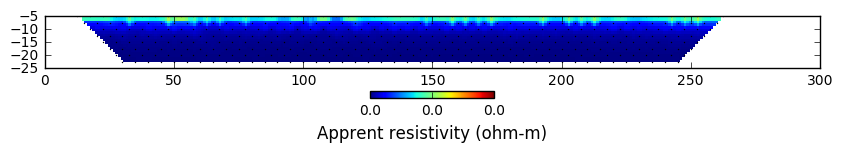

In [9]:
fname1 = "../data/ChungCheonDC/20150101000000.apr"
survey1 = readReservoirDC(fname1)
dobsAppres1 = survey1.dobs
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey1, ax)
cb = dat[2]
cb.set_label("Apprent resistivity (ohm-m)")
geom = np.hstack(dat[3])
dobsDC = dobsAppres1 * geom

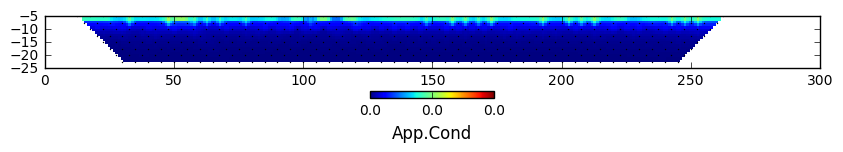

In [49]:
fname2 = "../data/ChungCheonDC/20151218000000.apr"
survey2 = readReservoirDC(fname2)
dobsAppres2 = survey2.dobs
fig, ax2 = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey2, ax2)
cb = dat[2]
#cb.set_label("Apparent resistivity (ohm-m)")
#geom = np.hstack(dat[3])
#dobsDC = dobsAppres2 * geom

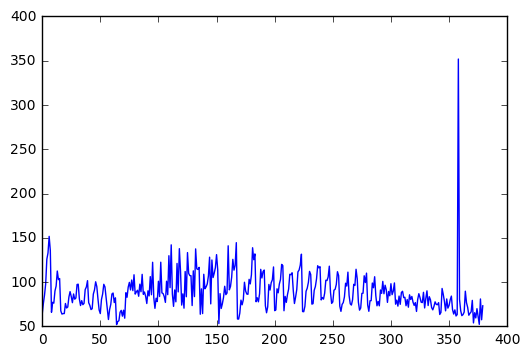

In [50]:
plt.plot(abs(dobsAppres1))

In [51]:
survey1 = readReservoirDC(fname1)
survey2 = readReservoirDC(fname2)
survey12 = readReservoirDC(fname2)

In [52]:
survey12.dobs = (abs(survey2.dobs-survey1.dobs) / abs(survey1.dobs))*100.

In [53]:
survey2.dobs.shape

(380,)

In [54]:
survey1.dobs.shape

(380,)

In [55]:
survey1.dobs.shape

(380,)

In [56]:
# print dobsAppres[6:]

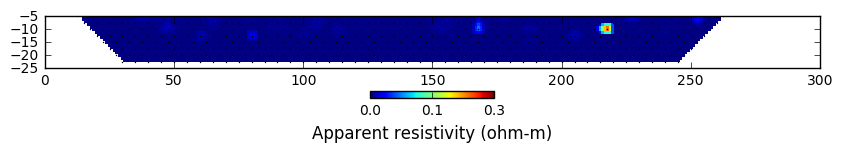

In [57]:
#survey2 = readReservoirDC(fname2)
#dobsAppres2 = survey.dobs
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey12, ax)
cb = dat[2]
cb.set_label("Apparent resistivity (ohm-m)")
geom = np.hstack(dat[3])
#dobsDC = dobsAppres12 * geom

/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in greater


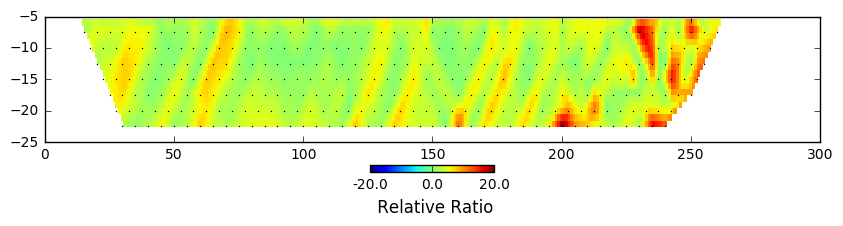

In [58]:
# surveyNew = removeRxsfromDC(survey, [346], DClow=40, DChigh=145, surveyType="2D")
surveyNew = removeRxsfromDC(survey12, [330], surveyType="2D")
surveyNew = removeRxsfromDC(survey12, [338], surveyType="2D")
surveyNew = removeRxsfromDC(survey12, [346], surveyType="2D")
surveyNew = removeRxsfromDC(survey12, [351], surveyType="2D")
surveyNew = removeRxsfromDC(survey12, [358], surveyType="2D")

fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='volt', sameratio=False,clim=(-20,20))
cb = dat[2]
cb.set_label(" Relative Ratio")
geom = np.hstack(dat[3])
dobsDC = surveyNew.dobs * geom

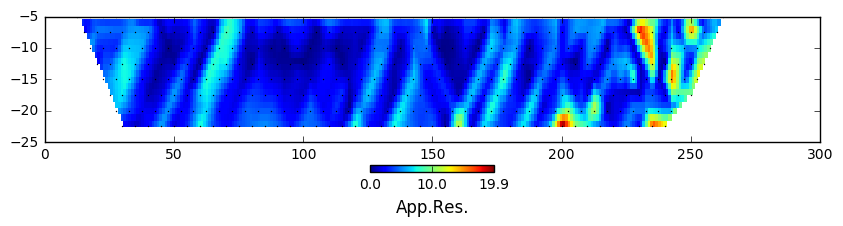

In [59]:
surveyNew.dobs = dobsDC
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False)

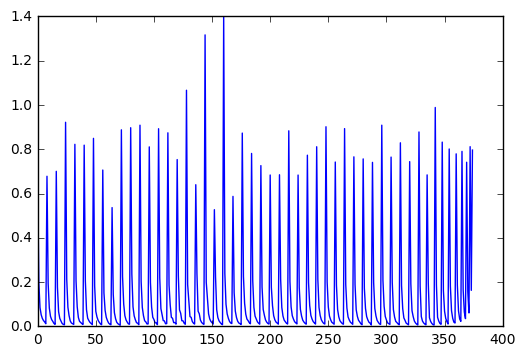

In [199]:
plt.plot(abs(dobsDC))

In [200]:
# problem = DC.Problem2D_CC(mesh)
cs = 2.5
npad = 6
hx = [(cs,npad, -1.3),(cs,160),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,20)]
mesh = Mesh.TensorMesh([hx, hy])
mesh = Mesh.TensorMesh([hx, hy],x0=[-mesh.hx[:6].sum()-0.25, -mesh.hy.sum()])

In [201]:
def from3Dto2Dsurvey(survey):
    srcLists2D = []
    nSrc = len(survey.srcList)

    for iSrc in range (nSrc):
        src = survey.srcList[iSrc]
        locsM = np.c_[src.rxList[0].locs[0][:,0], np.ones_like(src.rxList[0].locs[0][:,0])*-0.75] 
        locsN = np.c_[src.rxList[0].locs[1][:,0], np.ones_like(src.rxList[0].locs[1][:,0])*-0.75] 
        rx = DC.Rx.Dipole_ky(locsM, locsN)
        locA = np.r_[src.loc[0][0], -0.75]
        locB = np.r_[src.loc[1][0], -0.75]
        src = DC.Src.Dipole([rx], locA, locB)
        srcLists2D.append(src)
    survey2D = DC.Survey_ky(srcLists2D)
    return survey2D

In [202]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
# from pymatsolver import MumpsSolver

In [203]:
mapping = Maps.ExpMap(mesh)
survey2D = from3Dto2Dsurvey(surveyNew)
problem = DC.Problem2D_N(mesh, mapping=mapping)
problem.pair(survey2D)
# problem.Solver = MumpsSolver
m0 = np.ones(mesh.nC)*np.log(1e-2)

<function __main__.foo>

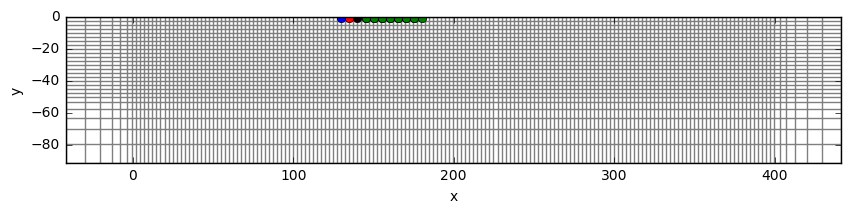

In [204]:
from ipywidgets import interact
nSrc = len(survey2D.srcList)
def foo(isrc):
    figsize(10, 5)
    mesh.plotImage(np.ones(mesh.nC)*np.nan, gridOpts={"color":"k", "alpha":0.5}, grid=True)
#     isrc=0
    src = survey2D.srcList[isrc]
    plt.plot(src.loc[0][0], src.loc[0][1], 'bo')
    plt.plot(src.loc[1][0], src.loc[1][1], 'ro')
    locsM = src.rxList[0].locs[0]
    locsN = src.rxList[0].locs[1]
    plt.plot(locsM[:,0], locsM[:,1], 'ko')
    plt.plot(locsN[:,0], locsN[:,1], 'go')
    plt.gca().set_aspect('equal', adjustable='box')
    
interact(foo, isrc=(0, nSrc-1, 1))

In [205]:
pred = survey2D.dpred(m0)

In [206]:
# data_anal = []
# nSrc = len(survey.srcList)
# for isrc in range(nSrc):
#     src = survey.srcList[isrc]    
#     locA = src.loc[0]
#     locB = src.loc[1]
#     locsM = src.rxList[0].locs[0]
#     locsN = src.rxList[0].locs[1]
#     rxloc=[locsM, locsN]
#     a = EM.Analytics.DCAnalyticHalf(locA, rxloc, 1e-3, earth_type="halfspace")
#     b = EM.Analytics.DCAnalyticHalf(locB, rxloc, 1e-3, earth_type="halfspace")
#     data_anal.append(a-b)
# data_anal = np.hstack(data_anal)

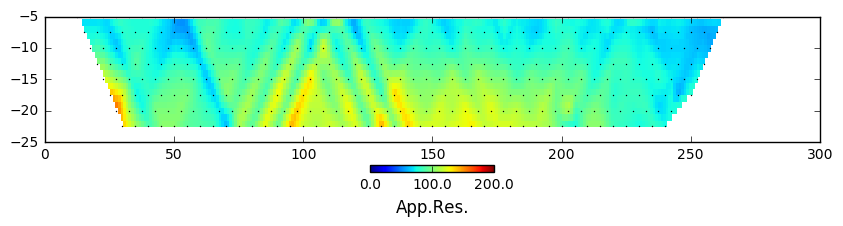

In [207]:
survey.dobs = pred
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False, scale="linear", clim=(0, 200))

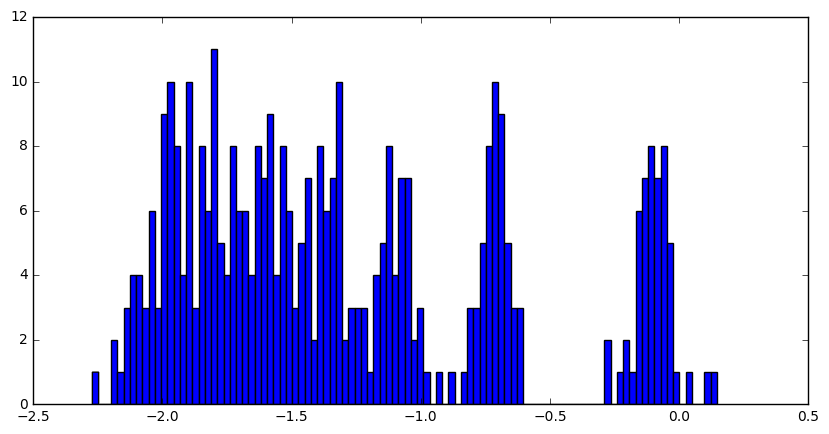

In [208]:
out = hist(np.log10(abs(dobsDC)), bins = 100)

In [209]:
weight =  1./abs(mesh.gridCC[:,1])**1.5

(<matplotlib.collections.QuadMesh at 0x10f41cad0>,)

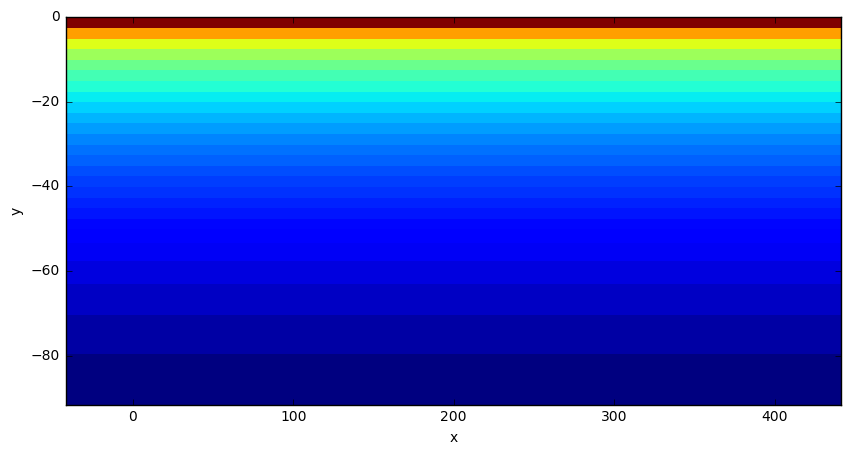

In [210]:
mesh.plotImage(np.log10(weight))

In [ ]:
survey2D.dobs = dobsDC
survey2D.eps = 10**(-2.3)
survey2D.std = 0.02
dmisfit = DataMisfit.l2_DataMisfit(survey2D)
regmap = Maps.IdentityMap(nP=int(mesh.nC))
reg = Regularization.Simple(mesh,mapping=regmap,cell_weights=weight)

opt = Optimization.ProjectedGNCG(maxIter=10)
opt.upper = np.log(1e0)
opt.lower = np.log(1./300)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

In [212]:
xc = opt.recall("xc")

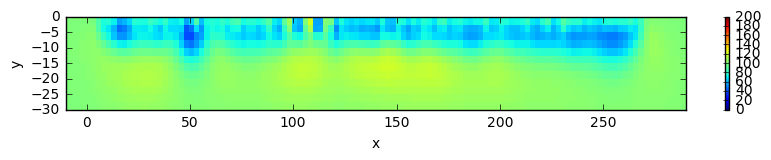

In [222]:
fig, ax = plt.subplots(1,1, figsize = (10, 1.2))
iteration = 4
sigma = mapping*xc[iteration]
dat = mesh.plotImage(1./sigma, grid=False, ax=ax, pcolorOpts={"cmap":"jet"}, clim=(0, 200))
ax.set_ylim(-30, 0)
ax.set_xlim(-10, 290)
plt.colorbar(dat[0])

In [223]:
print np.log10(sigma).min(), np.log10(sigma).max()

-2.08588346426 -1.59774543388


In [224]:
1./sigma.max()

39.604581992839918

In [225]:
1./sigma.min()

121.86625471191634

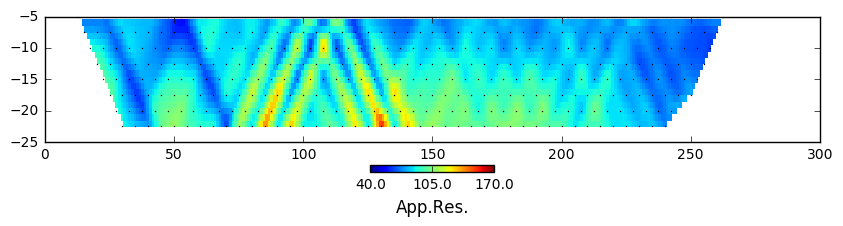

In [226]:
surveyNew.dobs = invProb.dpred
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False, clim=(40, 170))

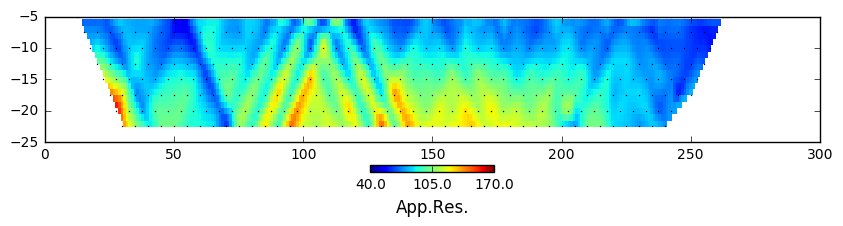

In [227]:
surveyNew.dobs = dobsDC
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='appr', sameratio=False, clim=(40, 170))

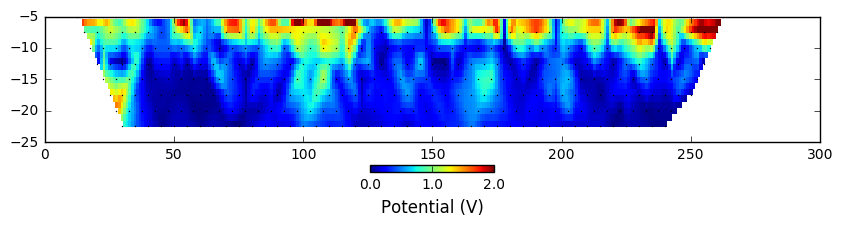

In [228]:
surveyNew.dobs = abs(dmisfit.Wd*(dobsDC-invProb.dpred))
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(surveyNew, ax, dtype='volt', sameratio=False, clim=(0, 2))

In [229]:
# sigma = np.ones(mesh.nC)
modelname = "sigma1218NBound.npy"
np.save(modelname, sigma)